In [1]:
%%time
import bayes3d as b

CPU times: user 9.45 s, sys: 7.08 s, total: 16.5 s
Wall time: 5.04 s


In [2]:
import numpy as np
import os
import jax
import jax.numpy as jnp
import trimesh
import time
import pickle
import bayes3d.transforms_3d as t3d
import bayes3d as b
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [4]:
#from carvekit.api.high import HiInterface
#import torch
'''interface = HiInterface(object_type="object",  # Can be "object" or "hairs-like".
                                batch_size_seg=5,
                                batch_size_matting=1,
                                device='cuda' if torch.cuda.is_available() else 'cpu',
                                seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
                                matting_mask_size=2048,
                                trimap_prob_threshold=220,#231,
                                trimap_dilation=15,
                                trimap_erosion_iters=20,
                                fp16=False)'''

def get_foreground_mask(image):
    #imgs = interface([j.get_rgb_image(image.rgb)])
    mask = jnp.array(imgs[0])[...,-1] > 0.5
    return mask

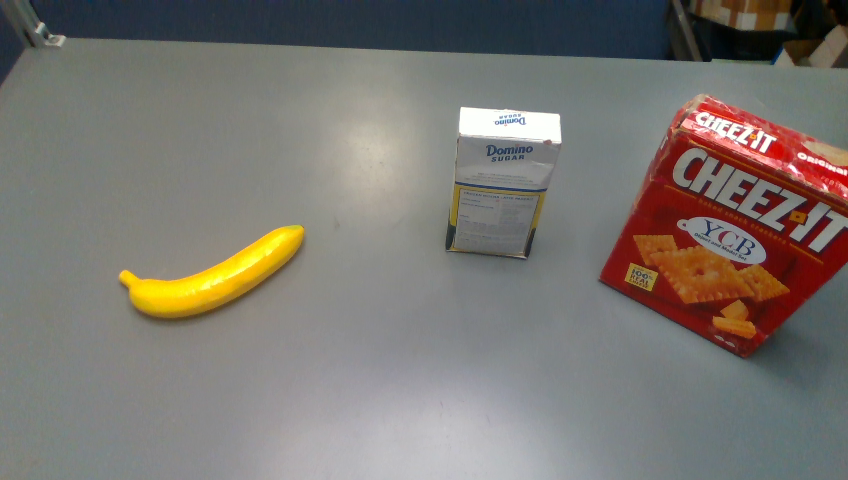

In [5]:
test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/cracker_sugar_banana_real.pkl.rgbds")
# test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/strawberry_error.pkl.rgbds")
# test_pkl_file = os.path.join(b.utils.get_assets_dir(),"sample_imgs/knife_spoon_box_real.pkl.rgbds")
with  open(test_pkl_file,'rb') as f:
    rgbds = pickle.load(f)
image = rgbds[0]
b.get_rgb_image(image.rgb)

In [6]:
import cv2

In [7]:
original_pc_image = b.t3d.unproject_depth_jit(image.depth, image.intrinsics)
scaling_factor = 0.3
intrinsics = b.camera.scale_camera_parameters(image.intrinsics, scaling_factor)

w,h = intrinsics.width, intrinsics.height
observed_point_cloud_image = jnp.array(cv2.resize(np.asarray(original_pc_image, dtype=original_pc_image.dtype), (w,h),interpolation=0).astype(original_pc_image.dtype))
print(intrinsics)

Intrinsics(height=144, width=254, fx=182.078613282, fy=181.955969238, cx=124.554812622, cy=77.66847839399999, near=0.001, far=5.0)


In [8]:
original_pc_image.shape

(480, 848, 3)

In [9]:
image.depth.shape

(480, 848)

In [10]:
observed_point_cloud_image.shape

(144, 254, 3)

In [11]:
plane_pose, plane_dims = b.utils.find_plane_and_dims(observed_point_cloud_image.reshape(-1,3),
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)
if plane_pose[:3,2][2] > 0:
    plane_pose = plane_pose @ t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), jnp.pi)
b.clear()
b.show_cloud("1", observed_point_cloud_image.reshape(-1,3))
b.show_pose("2", plane_pose)

In [12]:
#mask = get_foreground_mask(image)
#mask = np.array(mask) * 1.0
#mask = jnp.array(cv2.resize(np.asarray(mask, dtype=mask.dtype), (w,h),interpolation=0).astype(mask.dtype))


original_depth = image.depth
scaled_depth = cv2.resize(
    np.asarray(original_depth, dtype=original_depth.dtype), (w,h),interpolation=0).astype(
    original_depth.dtype)
#scaled_depth = scaled_depth * mask
observed_point_cloud_image = b.t3d.unproject_depth(scaled_depth, intrinsics)     
#b.get_depth_image(1.0*mask)

In [13]:
renderer = b.Renderer(intrinsics)
#model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models_limited")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)
SCALING_FACTOR = 3

table_mesh = b.utils.make_cuboid_mesh(3*plane_dims)
renderer.add_mesh(table_mesh)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (256, 160, 1024)


In [14]:
threedp3_likelihood_jit = jax.jit(jax.vmap(jax.vmap(
        b.threedp3_likelihood,
       in_axes=(None, None, None, 0, None, None)),
       in_axes=(None, 0, None, None, None, None)
), static_argnames=('filter_size',))


def score_trace(trace):
    reconstruction = renderer.render_many(
        trace.poses[None,...] , jnp.array(trace.ids)
    )

    print('obs size: ' + str(trace.observation.shape))
    print('reconstruction size: ' + str(reconstruction[0,:,:,:3].shape))

    p = b.threedp3_likelihood_jit(
        trace.observation, reconstruction[0,:,:,:3],
        trace.variance, trace.outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p

def render_image(trace):
    reconstruction = renderer.render_many(
        trace.poses , jnp.array(trace.ids)
    )
    return reconstruction

def score_traces(traces, renderer):
    reconstruction = renderer.render_many(
        traces.all_poses , jnp.array(traces.ids)
    )
    p = threedp3_likelihood_jit(
        traces.observation, reconstruction[:,:,:,:3],
        traces.variance, traces.all_outlier_prob, OUTLIER_VOLUME,
        5
    )
    return p


def viz_trace(trace):
    b.clear()
    key = jax.random.PRNGKey(10)
    b.show_cloud("1", trace.observation.reshape(-1,3))
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
    )
    b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=b.RED)

    colors = b.viz.distinct_colors(10)
    for i in range(len(trace.ids)):
        b.show_trimesh(f"obj_{i}", renderer.meshes[trace.ids[i]],color=colors[i])
        b.set_pose(f"obj_{i}", trace.poses[i])


Trace = namedtuple('Trace', ['poses', 'ids', 'variance', 'outlier_prob', 'observation'])
Traces = namedtuple('Traces', ['all_poses', 'ids', 'variance', 'all_outlier_prob', 'observation'])

In [15]:
VARIANCE = 0.00001
# VARIANCE_GRID = jnp.array([0.0001]).reshape(-1,1)
OUTLIER_GRID = jnp.linspace(0.01, 0.3, 3)
OUTLIER_VOLUME = 10.0**3

# grid_params = [
#     (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.1, jnp.pi/5, (11,11,1)),
#     (0.0, jnp.pi, (1,1,11*11)), (0.05, jnp.pi/5, (11,11,11)), (0.05, 0.0, (16,16,1))
# ]

grid_params = [
    (0.2, jnp.pi, (7,7,7)), (0.1, jnp.pi/3, (7,7,7)), (0.1, jnp.pi/5, (7,7,1)),
    (0.0, jnp.pi, (1,1,7*7)), (0.05, jnp.pi/5, (7,7,7)), (0.05, 0.0, (16,16,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

contact_poses_jit = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0,None, None)))


In [16]:
contact_param_gridding_schedule[0].shape

(343, 3)

In [17]:
contact_plane = plane_pose
# trace = Trace(
#     plane_pose[None,...], [21],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )

trace = Trace(
    jnp.zeros((0,4,4)), [],
    VARIANCE, 0.01,
    observed_point_cloud_image
)

In [18]:
viz_trace(trace)


In [19]:
trace.observation.shape

(144, 254, 3)

In [20]:
print(trace.ids)

[]


In [17]:
for _ in range(3):
    all_traces = []
    for obj_id in tqdm(range(21)):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            # swap axes for compatibility
            potential_poses = jnp.swapaxes(potential_poses, 0, 1)

            traces = Traces(
                potential_poses, trace.ids + [obj_id], trace.variance, OUTLIER_GRID, trace.observation
            )

            #print(traces)
            print(traces.ids)
            p = score_traces(traces, renderer)     
            #print(p.shape) 

            ii,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = Trace(
            traces.all_poses[ii], traces.ids, traces.variance, traces.all_outlier_prob[kk], traces.observation
        )

        # print(ii)
        # print(traces.all_poses.shape)
        # print(best_trace.poses.shape)
        # print(best_trace.observation.shape)

        all_traces.append(
            best_trace
        )


    scores = jnp.array([score_trace(t) for t in all_traces])

    print(b.utils.normalize_log_scores(scores))
    order = jnp.argsort(-scores)
    print(order)
    trace = all_traces[jnp.argmax(scores)]
    print(trace.ids)
    viz_trace(trace)


  0%|          | 0/21 [00:00<?, ?it/s]

[0]
[0]
[0]
[0]
[0]
[0]


  5%|▍         | 1/21 [00:11<03:40, 11.05s/it]

[1]
[1]
[1]
[1]
[1]


 10%|▉         | 2/21 [00:11<01:29,  4.72s/it]

[1]
[2]
[2]
[2]


 14%|█▍        | 3/21 [00:11<00:48,  2.71s/it]

[2]
[2]
[2]
[3]
[3]
[3]
[3]
[3]
[3]


 19%|█▉        | 4/21 [00:11<00:30,  1.77s/it]

[4]
[4]
[4]
[4]


 24%|██▍       | 5/21 [00:12<00:20,  1.26s/it]

[4]
[4]
[5]
[5]


 29%|██▊       | 6/21 [00:12<00:14,  1.05it/s]

[5]
[5]
[5]
[5]
[6]
[6]
[6]
[6]


 33%|███▎      | 7/21 [00:13<00:10,  1.33it/s]

[6]
[6]
[7]
[7]
[7]
[7]
[7]
[7]


 38%|███▊      | 8/21 [00:13<00:08,  1.60it/s]

[8]
[8]
[8]
[8]


 43%|████▎     | 9/21 [00:13<00:06,  1.86it/s]

[8]
[8]
[9]
[9]


 48%|████▊     | 10/21 [00:14<00:05,  2.10it/s]

[9]
[9]
[9]
[9]
[10]
[10]
[10]
[10]
[10]


 52%|█████▏    | 11/21 [00:14<00:04,  2.36it/s]

[10]
[11]
[11]
[11]


 57%|█████▋    | 12/21 [00:14<00:03,  2.58it/s]

[11]
[11]
[11]
[12]
[12]
[12]
[12]
[12]
[12]


 62%|██████▏   | 13/21 [00:15<00:03,  2.66it/s]

[13]
[13]
[13]
[13]
[13]


 67%|██████▋   | 14/21 [00:15<00:02,  2.80it/s]

[13]
[14]
[14]


 71%|███████▏  | 15/21 [00:15<00:02,  2.86it/s]

[14]
[14]
[14]
[14]
[15]
[15]
[15]
[15]
[15]


 76%|███████▌  | 16/21 [00:15<00:01,  2.94it/s]

[15]
[16]
[16]


 81%|████████  | 17/21 [00:16<00:01,  2.95it/s]

[16]
[16]
[16]
[16]
[17]
[17]
[17]
[17]
[17]


 86%|████████▌ | 18/21 [00:16<00:01,  3.00it/s]

[17]
[18]
[18]


 90%|█████████ | 19/21 [00:16<00:00,  2.99it/s]

[18]
[18]
[18]
[18]
[19]
[19]
[19]
[19]
[19]


 95%|█████████▌| 20/21 [00:17<00:00,  3.07it/s]

[19]
[20]
[20]
[20]


100%|██████████| 21/21 [00:17<00:00,  1.19it/s]

[20]
[20]
[20]


obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 

  0%|          | 0/21 [00:00<?, ?it/s]

[11, 0]
[11, 0]
[11, 0]
[11, 0]
[11, 0]
[11, 0]


  5%|▍         | 1/21 [00:01<00:29,  1.48s/it]

[11, 1]
[11, 1]
[11, 1]
[11, 1]


 10%|▉         | 2/21 [00:01<00:15,  1.26it/s]

[11, 1]
[11, 1]
[11, 2]
[11, 2]


 14%|█▍        | 3/21 [00:02<00:10,  1.71it/s]

[11, 2]
[11, 2]
[11, 2]
[11, 2]
[11, 3]
[11, 3]
[11, 3]
[11, 3]


 19%|█▉        | 4/21 [00:02<00:08,  2.03it/s]

[11, 3]
[11, 3]
[11, 4]
[11, 4]


 24%|██▍       | 5/21 [00:02<00:07,  2.28it/s]

[11, 4]
[11, 4]
[11, 4]
[11, 4]
[11, 5]
[11, 5]
[11, 5]
[11, 5]


 29%|██▊       | 6/21 [00:03<00:06,  2.45it/s]

[11, 5]
[11, 5]
[11, 6]
[11, 6]
[11, 6]
[11, 6]
[11, 6]
[11, 6]


 33%|███▎      | 7/21 [00:03<00:05,  2.60it/s]

[11, 7]
[11, 7]
[11, 7]
[11, 7]
[11, 7]


 38%|███▊      | 8/21 [00:03<00:04,  2.73it/s]

[11, 7]
[11, 8]
[11, 8]
[11, 8]


 43%|████▎     | 9/21 [00:04<00:04,  2.82it/s]

[11, 8]
[11, 8]
[11, 8]
[11, 9]
[11, 9]


 48%|████▊     | 10/21 [00:04<00:03,  2.94it/s]

[11, 9]
[11, 9]
[11, 9]
[11, 9]
[11, 10]
[11, 10]
[11, 10]
[11, 10]
[11, 10]


 52%|█████▏    | 11/21 [00:04<00:03,  2.94it/s]

[11, 10]
[11, 11]
[11, 11]


 57%|█████▋    | 12/21 [00:05<00:03,  2.97it/s]

[11, 11]
[11, 11]
[11, 11]
[11, 11]
[11, 12]
[11, 12]
[11, 12]
[11, 12]
[11, 12]


 62%|██████▏   | 13/21 [00:05<00:02,  2.97it/s]

[11, 12]
[11, 13]
[11, 13]


 67%|██████▋   | 14/21 [00:05<00:02,  3.00it/s]

[11, 13]
[11, 13]
[11, 13]
[11, 13]
[11, 14]
[11, 14]
[11, 14]
[11, 14]


 71%|███████▏  | 15/21 [00:06<00:02,  2.98it/s]

[11, 14]
[11, 14]
[11, 15]
[11, 15]


 76%|███████▌  | 16/21 [00:06<00:01,  3.02it/s]

[11, 15]
[11, 15]
[11, 15]
[11, 15]
[11, 16]
[11, 16]
[11, 16]
[11, 16]
[11, 16]


 81%|████████  | 17/21 [00:06<00:01,  3.02it/s]

[11, 16]
[11, 17]
[11, 17]
[11, 17]


 86%|████████▌ | 18/21 [00:07<00:00,  3.14it/s]

[11, 17]
[11, 17]
[11, 17]
[11, 18]
[11, 18]


 90%|█████████ | 19/21 [00:07<00:00,  3.20it/s]

[11, 18]
[11, 18]
[11, 18]
[11, 18]
[11, 19]
[11, 19]
[11, 19]
[11, 19]
[11, 19]


 95%|█████████▌| 20/21 [00:07<00:00,  3.22it/s]

[11, 19]
[11, 20]
[11, 20]
[11, 20]


100%|██████████| 21/21 [00:08<00:00,  2.62it/s]

[11, 20]
[11, 20]
[11, 20]
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)


obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 

  0%|          | 0/21 [00:00<?, ?it/s]

[11, 2, 0]
[11, 2, 0]
[11, 2, 0]
[11, 2, 0]
[11, 2, 0]
[11, 2, 0]


  5%|▍         | 1/21 [00:01<00:27,  1.38s/it]

[11, 2, 1]
[11, 2, 1]
[11, 2, 1]
[11, 2, 1]


 10%|▉         | 2/21 [00:01<00:14,  1.32it/s]

[11, 2, 1]
[11, 2, 1]
[11, 2, 2]
[11, 2, 2]
[11, 2, 2]
[11, 2, 2]
[11, 2, 2]
[11, 2, 2]


 14%|█▍        | 3/21 [00:02<00:10,  1.73it/s]

[11, 2, 3]
[11, 2, 3]
[11, 2, 3]
[11, 2, 3]


 19%|█▉        | 4/21 [00:02<00:08,  2.06it/s]

[11, 2, 3]
[11, 2, 3]
[11, 2, 4]
[11, 2, 4]
[11, 2, 4]
[11, 2, 4]
[11, 2, 4]
[11, 2, 4]


 24%|██▍       | 5/21 [00:02<00:07,  2.28it/s]

[11, 2, 5]
[11, 2, 5]
[11, 2, 5]
[11, 2, 5]
[11, 2, 5]


 29%|██▊       | 6/21 [00:03<00:05,  2.51it/s]

[11, 2, 5]
[11, 2, 6]
[11, 2, 6]


 33%|███▎      | 7/21 [00:03<00:05,  2.64it/s]

[11, 2, 6]
[11, 2, 6]
[11, 2, 6]
[11, 2, 6]
[11, 2, 7]
[11, 2, 7]
[11, 2, 7]
[11, 2, 7]
[11, 2, 7]


 38%|███▊      | 8/21 [00:03<00:04,  2.77it/s]

[11, 2, 7]
[11, 2, 8]
[11, 2, 8]
[11, 2, 8]


 43%|████▎     | 9/21 [00:04<00:04,  2.92it/s]

[11, 2, 8]
[11, 2, 8]
[11, 2, 8]
[11, 2, 9]
[11, 2, 9]


 48%|████▊     | 10/21 [00:04<00:03,  3.02it/s]

[11, 2, 9]
[11, 2, 9]
[11, 2, 9]
[11, 2, 9]
[11, 2, 10]
[11, 2, 10]
[11, 2, 10]
[11, 2, 10]
[11, 2, 10]


 52%|█████▏    | 11/21 [00:04<00:03,  3.10it/s]

[11, 2, 10]
[11, 2, 11]
[11, 2, 11]
[11, 2, 11]


 57%|█████▋    | 12/21 [00:04<00:02,  3.12it/s]

[11, 2, 11]
[11, 2, 11]
[11, 2, 11]
[11, 2, 12]
[11, 2, 12]


 62%|██████▏   | 13/21 [00:05<00:02,  3.08it/s]

[11, 2, 12]
[11, 2, 12]
[11, 2, 12]
[11, 2, 12]
[11, 2, 13]
[11, 2, 13]
[11, 2, 13]
[11, 2, 13]
[11, 2, 13]


 67%|██████▋   | 14/21 [00:05<00:02,  3.07it/s]

[11, 2, 13]
[11, 2, 14]
[11, 2, 14]
[11, 2, 14]


 71%|███████▏  | 15/21 [00:05<00:01,  3.14it/s]

[11, 2, 14]
[11, 2, 14]
[11, 2, 14]
[11, 2, 15]
[11, 2, 15]


 76%|███████▌  | 16/21 [00:06<00:01,  3.11it/s]

[11, 2, 15]
[11, 2, 15]
[11, 2, 15]
[11, 2, 15]
[11, 2, 16]
[11, 2, 16]
[11, 2, 16]
[11, 2, 16]
[11, 2, 16]


 81%|████████  | 17/21 [00:06<00:01,  3.13it/s]

[11, 2, 16]
[11, 2, 17]
[11, 2, 17]


 86%|████████▌ | 18/21 [00:06<00:00,  3.13it/s]

[11, 2, 17]
[11, 2, 17]
[11, 2, 17]
[11, 2, 17]
[11, 2, 18]
[11, 2, 18]
[11, 2, 18]
[11, 2, 18]
[11, 2, 18]


 90%|█████████ | 19/21 [00:07<00:00,  3.11it/s]

[11, 2, 18]
[11, 2, 19]
[11, 2, 19]
[11, 2, 19]


 95%|█████████▌| 20/21 [00:07<00:00,  3.10it/s]

[11, 2, 19]
[11, 2, 19]
[11, 2, 19]
[11, 2, 20]
[11, 2, 20]


100%|██████████| 21/21 [00:07<00:00,  2.67it/s]

[11, 2, 20]
[11, 2, 20]
[11, 2, 20]
[11, 2, 20]


obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 3)
obs size: (144, 254, 3)
reconstruction size: (144, 254, 

In [18]:
p.shape

(256, 3)

In [19]:
len(all_traces)

21

In [20]:
viz_trace(all_traces[17])

In [21]:
b.ycb_loader.MODEL_NAMES[17]

AttributeError: module 'bayes3d' has no attribute 'ycb_loader'

In [ ]:
trace.outlier_prob

Array(0.3, dtype=float32)

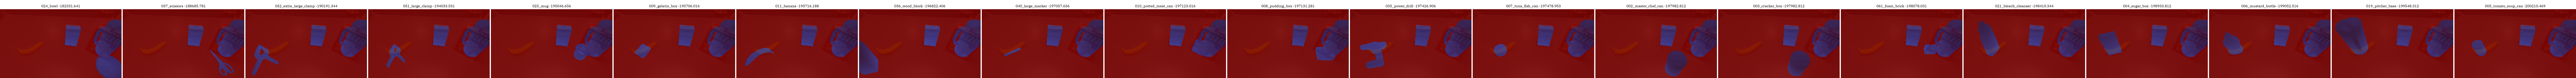

In [ ]:

rendered_images = [render_image(t) for t in all_traces]

rgb_viz = j.scale_image(j.get_rgb_image(image.rgb),scaling_factor)
j.multi_panel(
    [j.scale_image(j.overlay_image(rgb_viz,j.get_depth_image(rendered_images[i][:,:,2]),0.9),4) for i in order],
    labels=["{:s} {:0.3f}".format(b.ycb_loader.MODEL_NAMES[i], scores[i]) for i in order]
)

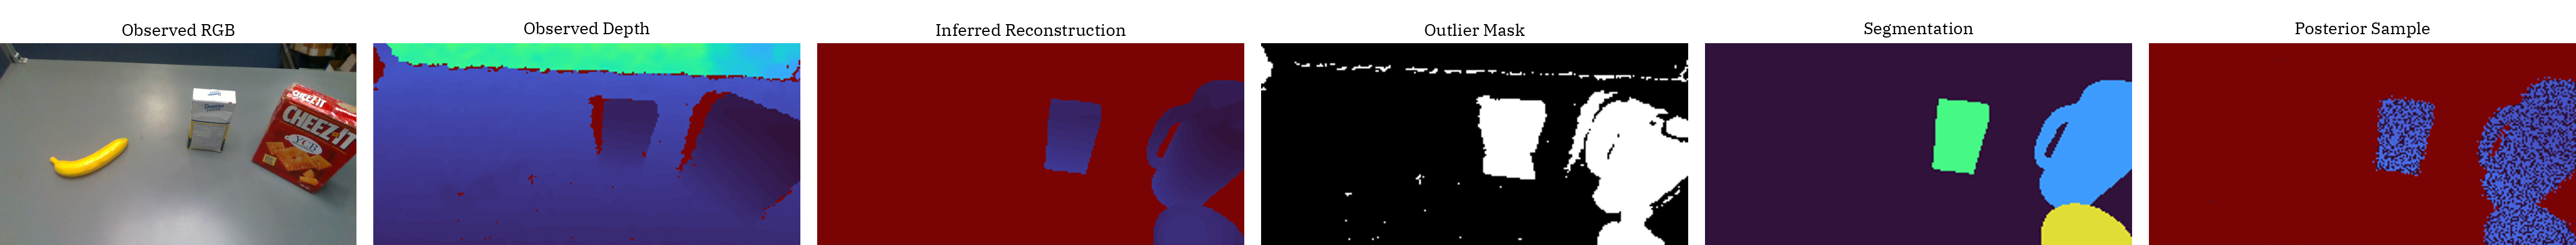

In [ ]:

rgb = image.rgb
reconstruction = renderer.render_multiobject(
    trace.poses, trace.ids
)
inliers = (
    (jnp.log(1.0 - trace.outlier_prob)  + j.threedp3_likelihood_per_pixel(
        observed_point_cloud_image, reconstruction[:,:,:3], trace.variance, 0.0, 1.0, 3
    ))
        >
    jnp.log(trace.outlier_prob / OUTLIER_VOLUME)
)

rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])

variance = trace.variance
key = jax.random.PRNGKey(12)

noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], jnp.eye(3)*variance, shape=reconstruction.shape[:2]
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)

viz2 = j.multi_panel(
    [
        j.scale_image(j.get_rgb_image(rgb),SCALING_FACTOR/4),
        j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(1.0 *inliers,cmap=plt.cm.gray, min=0.0, max=1.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(reconstruction[:,:,3], max=5.0), SCALING_FACTOR),
        j.scale_image(j.get_depth_image(img[:,:,2]), SCALING_FACTOR),
    ],
    labels=[
        "Observed RGB",
        "Observed Depth",
        "Inferred Reconstruction",
        "Outlier Mask",
        "Segmentation",
        "Posterior Sample",
    ],
    middle_width=30
)

viz2

In [ ]:
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, trace.observatiaon[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance
)

In [ ]:
    noisy_point_cloud_image = jax.random.multivariate_normal(
        key, trace.observation[:,:,:3].reshape(-1,3), jnp.eye(3)*trace.variance, shape=trace.observation.reshape(-1,3).shape[0]
    )
    b.show_cloud("2", noisy_point_cloud_image.reshape(-1,3), color=j.RED)


[Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32),
 Array(0.205, dtype=float32)]

In [ ]:
trace.variance

0.0001